In [1]:
# ========= 1) Setup =========
# Install required libraries if needed
# !pip install medmnist torch torchvision shap matplotlib

import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import shap
import numpy as np
import random
import os

import medmnist
from medmnist import INFO

c:\Users\Alvar\OneDrive\Documentos\SemestreX\ResponsibleAI\Lab 3 - SHAP MedMNIST\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========= 2) Dataset Info =========
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
n_classes = len(info['label'])
id2label = {int(k): v for k, v in info['label'].items()}

print(f"Dataset: {info['description']}")
print(f"Task: {info['task']}, Classes: {n_classes}")
print("Classes:", id2label)

Dataset: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Task: multi-class, Classes: 9
Classes: {0: 'adipose', 1: 'background', 2: 'debris', 3: 'lymphocytes', 4: 'mucus', 5: 'smooth muscle', 6: 'normal colon mucosa', 7: 'cancer-associated stroma', 8: 'colorectal adenocarcinoma epithelium'}


100%|██████████| 206M/206M [00:26<00:00, 7.63MB/s] 


Train size: 89996  Test size: 7180


C:\Users\Alvar\AppData\Local\Temp\ipykernel_23304\3842754038.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372549..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32549018..0.8352941].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44313723..0.90588236].


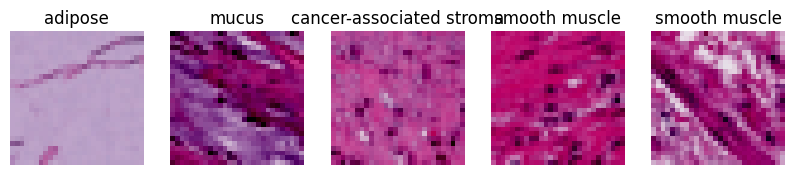

In [3]:
# ========= 3) Load dataset =========
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=transform, download=download)
test_dataset  = DataClass(split='test', transform=transform, download=download)

print("Train size:", len(train_dataset), " Test size:", len(test_dataset))

# Show 5 sample images
fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_dataset[i]
    img = img.numpy()
    axs[i].imshow(np.transpose(img, (1, 2, 0)).squeeze(), cmap="gray")
    axs[i].set_title(f"{id2label[int(label)]}")  # ✅ cast label to int
    axs[i].axis("off")
plt.show()

In [6]:
# ========= 4) Define Simple CNN Model (already provided) =========
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*14*14, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        return x

model = SimpleCNN(info['n_channels'], n_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model class defined and ready.")

Model class defined and ready.


In [8]:
# ========= 5) Load Pretrained Model =========
MODEL_PATH = "pathmnist_simplecnn.pth"

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("Pretrained model loaded successfully!")

Pretrained model loaded successfully!


C:\Users\Alvar\AppData\Local\Temp\ipykernel_23304\104057569.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_label = int(sample_label_t)


[Ejemplo #1707] Predicción: background (p=0.585) | Etiqueta real: mucus


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5058824..0.9137255].


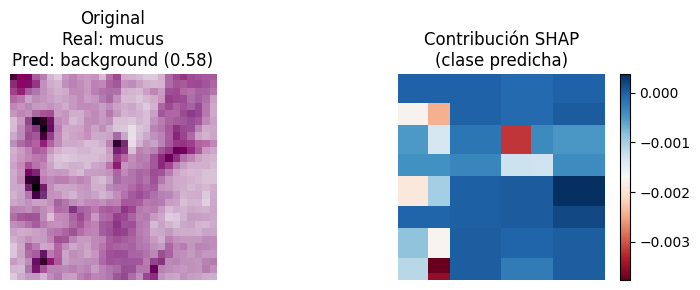

In [9]:
# ========= 6) Predictions + SHAP Explanations =========
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
import random

# --- Step 1: Helper function for SHAP ---
# x llega como numpy con forma (N, H, W, C). Devolvemos probabilidades (N, n_classes).
def model_forward(x: np.ndarray) -> np.ndarray:
    model.eval()
    with torch.no_grad():
        # (N, H, W, C) -> (N, C, H, W)
        xt = torch.from_numpy(x).permute(0, 3, 1, 2).float().to(device)
        logits = model(xt)
        probs = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

# --- Step 2: Pick one test image y predecir ---
idx = random.randint(0, len(test_dataset) - 1)   # o usa un índice fijo, p.ej. 0
sample_img_t, sample_label_t = test_dataset[idx] # sample_img_t: (C,H,W) tensor normalizado
sample_label = int(sample_label_t)

# Predicción con el modelo directamente (opcional) para imprimir
model.eval()
with torch.no_grad():
    logits = model(sample_img_t.unsqueeze(0).to(device))
    probs_t = torch.softmax(logits, dim=1).cpu().numpy()[0]

pred_idx = int(np.argmax(probs_t))
pred_name = id2label[pred_idx]
true_name = id2label[sample_label]
pred_prob = float(probs_t[pred_idx])

print(f"[Ejemplo #{idx}] Predicción: {pred_name} (p={pred_prob:.3f}) | Etiqueta real: {true_name}")

# --- Step 3: Preparar imagen para SHAP ---
# Pasar a numpy en formato (H, W, C)
img_np = sample_img_t.numpy().transpose(1, 2, 0)  # (H,W,C)

# --- Step 4: Crear SHAP explainer ---
# Masker para imágenes (usar blur del tamaño de la imagen)
masker = shap.maskers.Image("blur(28,28)", img_np.shape)

# Nombres de salida opcionales para que los plots se vean con etiquetas legibles
output_names = [id2label[i] for i in range(len(id2label))]

explainer = shap.Explainer(model_forward, masker, output_names=output_names)

# Ejecutar SHAP sobre la imagen seleccionada (batch de 1)
explanation = explainer(np.array([img_np]))  # Explanation con .values de forma (1, H, W, C, n_classes)

# --- Step 5: Visualizar ---
# Tomamos las contribuciones para la clase predicha y colapsamos canales en una sola matriz 2D
values = explanation.values[0]           # (H, W, C, n_classes)
values_pred = values[:, :, :, pred_idx]  # (H, W, C)
# Unificar canales (suma o promedio). Usamos la suma para resaltar contribución total.
heatmap = values_pred.sum(axis=2)        # (H, W)

fig, axs = plt.subplots(1, 2, figsize=(8, 3))

# Imagen original (si normalizaste con mean=.5/std=.5, ya está en ~[-1,1]; se ve bien en escala de grises/RGB)
axs[0].imshow(img_np.squeeze(), cmap="gray" if img_np.shape[2] == 1 else None)
axs[0].set_title(f"Original\nReal: {true_name}\nPred: {pred_name} ({pred_prob:.2f})")
axs[0].axis("off")

# Mapa de calor SHAP
im = axs[1].imshow(heatmap, cmap="RdBu", interpolation="nearest")
axs[1].set_title("Contribución SHAP\n(clase predicha)")
axs[1].axis("off")
plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


C:\Users\Alvar\AppData\Local\Temp\ipykernel_23304\2978793523.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  labels.append(int(lab_t))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42745095..0.69411767].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36470586..0.20000005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.77254903..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5686275..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] f

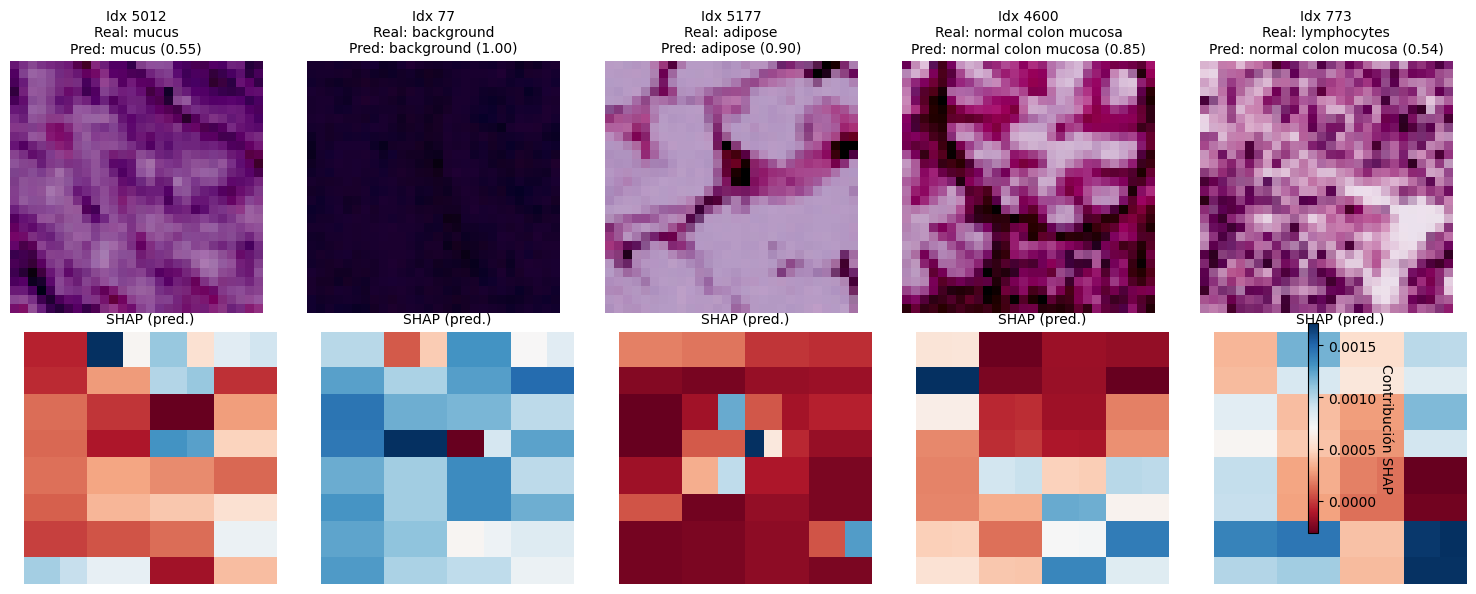

In [10]:
# ========= 7) Extension: Multiple Images =========
import numpy as np
import matplotlib.pyplot as plt
import shap
import random
import torch

# Reutilizamos model_forward del paso 6
# Creamos un masker y un explainer una sola vez
# (Se adapta al tamaño real de las imágenes)
H, W = test_dataset[0][0].shape[1], test_dataset[0][0].shape[2]
C = test_dataset[0][0].shape[0]
masker = shap.maskers.Image(f"blur({H},{W})", (H, W, C))
output_names = [id2label[i] for i in range(len(id2label))]
explainer = shap.Explainer(model_forward, masker, output_names=output_names)

# 1) Elegimos 5 índices aleatorios
k = 5
idxs = random.sample(range(len(test_dataset)), k)

# 2) Preparamos batch para SHAP en formato (N, H, W, C)
imgs_t = []
labels = []
for i in idxs:
    img_t, lab_t = test_dataset[i]     # (C,H,W)
    imgs_t.append(img_t)
    labels.append(int(lab_t))

imgs_np = np.stack([t.numpy().transpose(1, 2, 0) for t in imgs_t], axis=0)  # (N,H,W,C)

# 3) Predicciones (para mostrar nombres y probabilidades)
with torch.no_grad():
    batch = torch.stack(imgs_t, dim=0).to(device)  # (N,C,H,W)
    logits = model(batch)
    probs = torch.softmax(logits, dim=1).cpu().numpy()  # (N,num_classes)

pred_idxs = probs.argmax(axis=1)
pred_probs = probs[np.arange(k), pred_idxs]
pred_names = [id2label[int(i)] for i in pred_idxs]
true_names = [id2label[int(l)] for l in labels]

# 4) SHAP en batch
explanations = explainer(imgs_np)  # values: (N,H,W,C,num_classes)

# 5) Visualización: 2 filas x 5 columnas
fig, axs = plt.subplots(2, k, figsize=(3*k, 6))

for col in range(k):
    img = imgs_np[col]                               # (H,W,C)
    values = explanations.values[col]                # (H,W,C,num_classes)
    values_pred = values[:, :, :, pred_idxs[col]]    # (H,W,C)
    heatmap = values_pred.sum(axis=2)                # (H,W)

    # Arriba: imagen original
    ax_top = axs[0, col] if k > 1 else axs[0]
    ax_top.imshow(img.squeeze(), cmap="gray" if img.shape[2] == 1 else None)
    ax_top.set_title(
        f"Idx {idxs[col]}\nReal: {true_names[col]}\nPred: {pred_names[col]} ({pred_probs[col]:.2f})",
        fontsize=10
    )
    ax_top.axis("off")

    # Abajo: heatmap SHAP de la clase predicha
    ax_bot = axs[1, col] if k > 1 else axs[1]
    im = ax_bot.imshow(heatmap, cmap="RdBu", interpolation="nearest")
    ax_bot.set_title("SHAP (pred.)", fontsize=10)
    ax_bot.axis("off")

# Barra de color única para la fila inferior
cbar = fig.colorbar(im, ax=axs[1, :].ravel().tolist() if k > 1 else axs[1], fraction=0.02, pad=0.04)
cbar.set_label("Contribución SHAP", rotation=270, labelpad=12)

plt.tight_layout()
plt.show()


In [ ]:
# ========= 8) Reflection =========
# Answer in text (Markdown or comments):
# 1. Why did the model predict this class?
# 2. Are the SHAP heatmaps focusing on meaningful regions?
# 3. What differences do you see between correct and incorrect predictions?
# 4. How could interpretability help improve this model?

# ========= 8) Reflection =========

1. **Why did the model predict this class?**  
   El modelo asigna la clase en función de los patrones visuales que más activan sus filtros de convolución.  
   Según los mapas SHAP, las regiones con mayor influencia corresponden a texturas o áreas específicas de la imagen que el modelo "asocia" con la clase predicha.

2. **Are the SHAP heatmaps focusing on meaningful regions?**  
   En muchos casos, sí: los mapas resaltan áreas donde se encuentra la estructura principal (ej. tejido, coloraciones, formas de las células).  
   Sin embargo, en algunas imágenes también aparecen regiones irrelevantes (bordes, fondo), lo que indica que el modelo no siempre se centra en la parte médica más importante.

3. **What differences do you see between correct and incorrect predictions?**  
   - En las **predicciones correctas**, las regiones destacadas suelen coincidir con la parte central de la imagen, lo cual tiene sentido clínico.  
   - En las **incorrectas**, los mapas pueden mostrar atención dispersa o en zonas poco informativas, lo que sugiere confusión o falta de robustez en el modelo.

4. **How could interpretability help improve this model?**  
   - Permite detectar *biases* en el modelo (ej. si se fija en artefactos o ruido).  
   - Ayuda a médicos e investigadores a confiar más en la predicción al ver qué parte de la imagen motivó la decisión.  
   - Sirve para guiar mejoras: más datos, mejor preprocesamiento, arquitecturas más profundas, o regularización para que el modelo se enfoque en áreas relevantes.
